In [8]:
%pip install google.generativeai

Note: you may need to restart the kernel to use updated packages.


In [9]:
%pip install lseg.data

Note: you may need to restart the kernel to use updated packages.


In [10]:
%pip install pandas_ta

Note: you may need to restart the kernel to use updated packages.


In [11]:
import google.generativeai as genai
import os
import lseg.data as ld
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#plt.style.use('dark_background')
import warnings
warnings.filterwarnings('ignore')

from numpy.random import random, uniform, dirichlet, choice
from numpy.linalg import inv
from scipy.optimize import minimize
from matplotlib.ticker import FuncFormatter
import math
from datetime import datetime, timedelta, date
import pandas_datareader.data as web
import pandas_ta as ta

In [12]:
import os
os.environ["LD_LIB_CONFIG_PATH"] = "../configuration"

In [13]:
GOOGLE_API_KEY = ''
genai.configure(api_key=GOOGLE_API_KEY)


In [14]:
ld.open_session()

<lseg.data.session.Definition object at 0x12c2d7ad0 {name='workspace'}>

In [15]:
import datetime as dt
today = dt.datetime.today()
delta_day = today - dt.timedelta(days=365*2)
print(delta_day, today)

2023-04-03 18:41:14.958862 2025-04-02 18:41:14.958862


In [16]:
def get_timeseries_from_refinitiv(RIC: str, nombre: str):
    """
    Retrieves the pricing history, of a specific RIC and writes to the location nombre.
    
    Parameters
    ----------
    RIC: str 
    nombre: str
    
    Returns
    -------
    location of a pandas.DataFrame
    """
    df = ld.get_history(RIC, fields = ['TR.PriceClose'],
                          start = delta_day, 
                          end = today, 
                          interval="daily")
    df.to_parquet(nombre, compression='gzip')
    return f"pandas file written to {nombre}"


In [17]:
%pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


In [18]:
get_timeseries_from_refinitiv('NVDA.O', 'NVDA')

'pandas file written to NVDA'

In [19]:
pd.read_parquet('NVDA') 

NVDA.O,Price Close
Date,
2023-04-03,27.965
2023-04-04,27.453
2023-04-05,26.881
2023-04-06,27.037
2023-04-10,27.579
...,...
2025-03-27,111.43
2025-03-28,109.67
2025-03-31,108.38


In [20]:
operation_tools = [get_timeseries_from_refinitiv]

In [21]:
# These are the Python functions defined above.
operation_tools = [get_timeseries_from_refinitiv]

instruction = """You are a helpful chatbot that can interact with an python environment and create pandas dataframes. 
You will take the users questions and turn them into parameters that you will pass to the tools
available. Once you have the information you need, you will answer the user's question returning the answer of the function. 
Use get_timeseries_from_refinitiv to return a pandas dataframe associated with the RIC specified."""

model = genai.GenerativeModel(
    "models/gemini-1.5-flash-latest", tools=operation_tools, system_instruction=instruction
)

# Define a retry policy. The model might make multiple consecutive calls automatically
# for a complex query, this ensures the client retries if it hits quota limits.
from google.api_core import retry

retry_policy = {"retry": retry.Retry(predicate=retry.if_transient_error)}

# Start a chat with automatic function calling enabled.
chat = model.start_chat(enable_automatic_function_calling=True)

In [22]:
response = chat.send_message(
    "Get the dateaframe with timeseries for the RIC NVDA.O and save it to NVDA "
)

In [23]:
print(response)

response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "The timeseries for the RIC NVDA.O has been saved to NVDA."
              }
            ],
            "role": "model"
          },
          "finish_reason": "STOP",
          "avg_logprobs": -0.16643869175630457
        }
      ],
      "usage_metadata": {
        "prompt_token_count": 215,
        "candidates_token_count": 17,
        "total_token_count": 232
      },
      "model_version": "gemini-1.5-flash-latest"
    }),
)


In [24]:
pd.read_parquet('NVDA') 

NVDA.O,Price Close
Date,
2023-04-03,27.965
2023-04-04,27.453
2023-04-05,26.881
2023-04-06,27.037
2023-04-10,27.579
...,...
2025-03-27,111.43
2025-03-28,109.67
2025-03-31,108.38


In [25]:
df = ld.get_history("NVDA.O", fields = ['TR.PriceClose', "TR.PriceHigh", "TR.PriceLow", "TR.Volume"],
                          start = delta_day, 
                          end = today, 
                          interval="daily")

df

NVDA.O,Price Close,Price High,Price Low,Volume
Date,,,,
2023-04-03,27.965,28.0,27.336,398715599
2023-04-04,27.453,28.0,27.307,368591529
2023-04-05,26.881,26.998,26.395,515014739
2023-04-06,27.037,27.08,26.427,397654339
2023-04-10,27.579,27.62099,26.669,395278549
...,...,...,...,...
2025-03-27,111.43,114.45,110.66,236902055
2025-03-28,109.67,112.87,109.0701,229872549
2025-03-31,108.38,110.955,103.65,299212653


In [26]:
df=df.rename(columns={"Price Close":"close", "Price High": "high", "Price Low":"low" , "Volume":"volume"})

In [27]:
df["chaikin_oscillator"]=ta.adosc(high=df['high'], low=df['low'], close=df['close'], volume=df['volume'], fast=3, slow=10)

In [28]:
df

NVDA.O,close,high,low,volume,chaikin_oscillator
Date,,,,,
2023-04-03,27.965,28.0,27.336,398715599,NaN
2023-04-04,27.453,28.0,27.307,368591529,NaN
2023-04-05,26.881,26.998,26.395,515014739,NaN
2023-04-06,27.037,27.08,26.427,397654339,NaN
2023-04-10,27.579,27.62099,26.669,395278549,NaN
...,...,...,...,...,...
2025-03-27,111.43,114.45,110.66,236902055,-8.121556e+06
2025-03-28,109.67,112.87,109.0701,229872549,-8.746971e+07
2025-03-31,108.38,110.955,103.65,299212653,-8.389301e+07


In [29]:
ax = df[['close', 'chaikin_oscillator']].plot(figsize=(14, 4),
                              rot=0,
                              secondary_y='chaikin_oscillator', style=['-', '--'])

ax.set_xlabel('')
sns.despine()
plt.tight_layout()


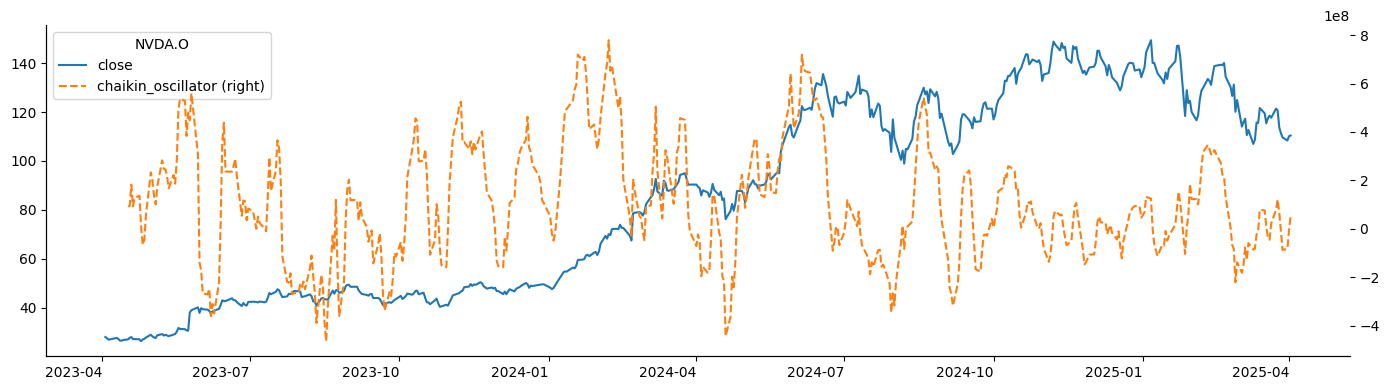

In [30]:
plt.show()

In [31]:
promedio = df['volume'].mean()

In [32]:
df['chaikin_normalized'] = df['chaikin_oscillator']/promedio
df

NVDA.O,close,high,low,volume,chaikin_oscillator,chaikin_normalized
Date,,,,,,
2023-04-03,27.965,28.0,27.336,398715599,NaN,NaN
2023-04-04,27.453,28.0,27.307,368591529,NaN,NaN
2023-04-05,26.881,26.998,26.395,515014739,NaN,NaN
2023-04-06,27.037,27.08,26.427,397654339,NaN,NaN
2023-04-10,27.579,27.62099,26.669,395278549,NaN,NaN
...,...,...,...,...,...,...
2025-03-27,111.43,114.45,110.66,236902055,-8.121556e+06,-0.020415
2025-03-28,109.67,112.87,109.0701,229872549,-8.746971e+07,-0.219876
2025-03-31,108.38,110.955,103.65,299212653,-8.389301e+07,-0.210885


In [33]:
df.chaikin_normalized.replace((np.inf, -np.inf), np.nan).dropna().describe()

count    493.000000
mean       0.258030
std        0.596478
min       -1.168375
25%       -0.152316
50%        0.174739
75%        0.645677
max        1.957958
Name: chaikin_normalized, dtype: float64

In [34]:
q = 0.005
chaikin_normalized = df.chaikin_normalized.replace((np.inf, -np.inf), np.nan).dropna()
with sns.axes_style('white'):
    sns.distplot(chaikin_normalized.clip(lower=chaikin_normalized.quantile(q),
                     upper=chaikin_normalized.quantile(1-q)));

    sns.despine()

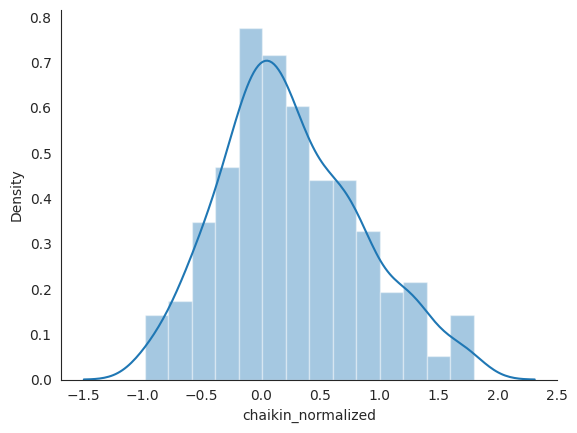

In [35]:
plt.show()

In [36]:
# Generate Buy and Sell signals
df['Buy_Signal'] = np.where((df['chaikin_normalized'] > 0), 1, 0)
df['Sell_Signal'] = np.where((df['chaikin_normalized'] < 0), -1, 0)

In [37]:

def get_chaikin_normalized(RIC: str):
    """
    Obtiene los datos históricos del RIC y los normaliza.
    Calcula el indicador de chaikin y con ello da señales de compra o venta. 
    
    Parameters
    ----------
    RIC: str 
    
    Returns
    -------
    Regresa una recomendación de compra o venta.
    location of a pandas.DataFrame
    """
    today = datetime.today()
    delta_day = today - timedelta(days=180)

    # Obtener datos
    df = ld.get_history(RIC, fields=['TR.PriceClose', 'TR.PriceHigh', 'TR.PriceLow', 'TR.Volume'],
                        start=delta_day, end=today, interval='daily')
    
    df = df.rename(columns={
        "Price Close": "close",
        "Price High": "high",
        "Price Low": "low",
        "Volume": "volume"
    })

    # Calcular Chaikin Oscillator
    df["chaikin_oscillator"] = ta.adosc(high=df['high'], low=df['low'],
                                        close=df['close'], volume=df['volume'],
                                        fast=3, slow=10)

    # Normalizar el oscillator
    df['chaikin_normalized'] = (df['chaikin_oscillator'] - df['chaikin_oscillator'].mean()) / df['chaikin_oscillator'].std()

    # Señales de compra y venta
    df['Buy_Signal'] = np.where(df['chaikin_normalized'] > 0, 1, 0)
    df['Sell_Signal'] = np.where(df['chaikin_normalized'] < 0, -1, 0)

    # Genera el gráfico
    ax = df[['close', 'chaikin_oscillator']].plot(figsize=(14, 4),
                                                  rot=0,
                                                  secondary_y='chaikin_oscillator',
                                                  style=['-', '--'])
    ax.set_xlabel('')
    sns.despine()
    plt.tight_layout()
    plt.savefig('chaikin_oscillator_plot.png', dpi=300)

    # Guardar como archivo CSV (opcional)
    df.to_csv("chaikin_normalized", index=True)

    if df.iloc[-1]["Buy_Signal"] == 1:
        signal="comprar"
    else:
        signal="vender"
    return f"indicador chaikin recomienda {signal}"


In [38]:
get_chaikin_normalized("NVDA.O")

'indicador chaikin recomienda comprar'

In [39]:
df = pd.read_csv("chaikin_normalized")

In [40]:
df.iloc[-1]["Buy_Signal"]

1

In [41]:
import matplotlib.image as mpimg

<class 'numpy.ndarray'>


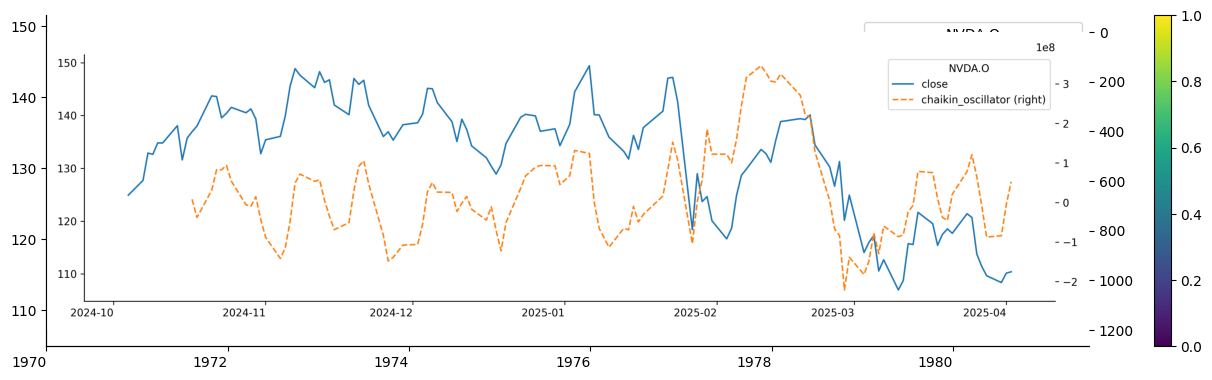

In [42]:
image = mpimg.imread("chaikin_oscillator_plot.png")
print(type(image))
image.shape
plt.imshow(image)
plt.colorbar()
plt.show()

In [43]:
operation_tools = [get_timeseries_from_refinitiv, chaikin_normalized]

In [44]:
# These are the Python functions defined above.

instruction = """You are a helpful chatbot that can interact with an python environment and create pandas dataframes. 
You will take the users questions and turn them into parameters that you will pass to the tools
available. Once you have the information you need, you will answer the user's question returning the answer of the function. 
Use get_timeseries_from_refinitiv to return a pandas dataframe associated with the RIC specified."""

model = genai.GenerativeModel(
    "models/gemini-1.5-flash-latest", tools=operation_tools, system_instruction=instruction
)

# Define a retry policy. The model might make multiple consecutive calls automatically
# for a complex query, this ensures the client retries if it hits quota limits.
from google.api_core import retry

retry_policy = {"retry": retry.Retry(predicate=retry.if_transient_error)}

# Start a chat with automatic function calling enabled.
chat = model.start_chat(enable_automatic_function_calling=True)

TypeError: Invalid input type. Expected an instance of `genai.FunctionDeclarationType`.
However, received an object of type: <class 'float'>.
Object Value: 0.2285450264411197